In [1]:
# Import necessary packages
import os
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import xarray as xr

from hy2dl.evaluation.metrics import nse

color_palette = {"LSTM": "#4daf4a", "benchmark": "#377eb8", "MTS": "#ff7f00", "sMTS": "#984ea3"}

Part 1. Benchmark CAMELS_GB.


Lees, T., Buechel, M., Anderson, B., Slater, L., Reece, S., Coxon, G., & Dadson, S. J. (2021). Benchmarking data-driven rainfall–runoff models in Great Britain: A comparison of long short-term memory (LSTM)-based models with four lumped conceptual models. Hydrology and Earth System Sciences, 25(10), 5517–5534. https://doi.org/10.5194/hess-25-5517-2021

In [80]:
# Read the results generated by Lees et al. (2021)
path_results_less = "Lees2021/metrics.nc"
lees_metrics = xr.open_dataset(path_results_less)
df_NSE_less = lees_metrics.sel(model="LSTM")["nse"].to_pandas()
df_NSE_less = df_NSE_less.to_frame(name="Benchmark_Lees")
df_NSE_less.index = df_NSE_less.index.astype(str)
df_NSE_less.index.name = "basin_id"

In [81]:
# Read the results generated using Hy2DL
path_results_LSTM = ["Lees2021/LSTM_CAMELS_GB_seed_1", 
                     "Lees2021/LSTM_CAMELS_GB_seed_2", 
                     "Lees2021/LSTM_CAMELS_GB_seed_3",
                     "Lees2021/LSTM_CAMELS_GB_seed_4"]

# Create ensemble
lstm_results = {}
for i, ensemble_member in enumerate(path_results_LSTM):
    with open(ensemble_member + "/test_results.pickle", "rb") as f:
        info_lstm = pickle.load(f)
    # Iterate over each basin
    for basin in info_lstm.keys():
        y_sim = info_lstm[basin]["y_sim"]
        if i == 0:  # If this is the first ensemble member, initialize the DataFrame with y_obs and y_sim
            y_obs = info_lstm[basin]["y_obs"]
            lstm_results[basin] = pd.DataFrame(data={"y_obs": y_obs, f"y_sim_ens_{i + 1}": y_sim}, index=y_obs.index)
        else:  # For subsequent ensemble members, add y_sim as a new column
            lstm_results[basin][f"y_sim_ens_{i + 1}"] = y_sim

# Calculate the median of the simulated values and add it as a new column
for basin in lstm_results.keys():
    # Select only the y_sim columns
    y_sim_columns = [col for col in lstm_results[basin].columns if col.startswith("y_sim_ens_")]
    lstm_results[basin]["y_sim"] = lstm_results[basin][y_sim_columns].median(axis=1)

df_NSE_CAMELS_GB = pd.DataFrame(
    data={"basin_id": list(lstm_results.keys()), "LSTM": np.round(nse(df_results=lstm_results, average=False), 3)}
).set_index("basin_id")

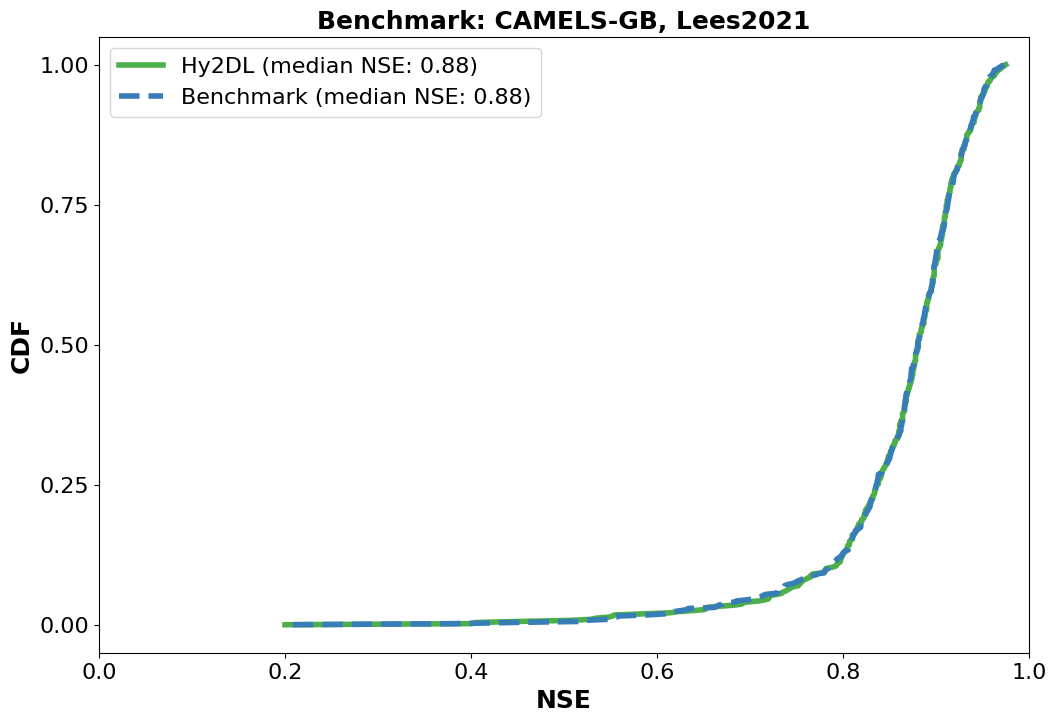

In [82]:
df_NSE_comparison = pd.concat([df_NSE_CAMELS_GB, df_NSE_less], axis=1)
df_NSE_comparison = df_NSE_comparison.apply(lambda x: x.sort_values().values).reset_index(drop=True)
df_NSE_comparison["cdf"] = np.arange(len(df_NSE_comparison)) / (len(df_NSE_comparison) - 1)

# Create plot
plt.rcParams["figure.figsize"] = (12, 8)

plt.plot(
    df_NSE_comparison["LSTM"],
    df_NSE_comparison["cdf"],
    linewidth=4,
    label=f"Hy2DL (median NSE: {df_NSE_comparison['LSTM'].median():.2f})",
    color=color_palette["LSTM"],
)
plt.plot(
    df_NSE_comparison["Benchmark_Lees"],
    df_NSE_comparison["cdf"],
    linewidth=4,
    linestyle="--",
    label=f"Benchmark (median NSE: {df_NSE_comparison['Benchmark_Lees'].median():.2f})",
    color=color_palette["benchmark"],
)


plt.xlim(0, 1)
plt.xlabel("NSE", fontsize=18, fontweight="bold")
plt.ylabel("CDF", fontsize=18, fontweight="bold")
plt.xticks(fontsize=16)
plt.yticks([i * 0.25 for i in range(5)], fontsize=16)

plt.legend(loc="upper left", fontsize=16)
plt.title("Benchmark: CAMELS-GB, Lees2021", fontsize=18, fontweight="bold")
#plt.savefig("Benchmark_Lees2021.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.show()

Part 2. Benchmark CAMELS_US.

Kratzert, F., Klotz, D., Shalev, G., Klambauer, G., Hochreiter, S., & Nearing, G. (2019). Towards learning universal, regional, and local hydrological behaviors via machine learning applied to large-sample datasets. Hydrology and Earth System Sciences, 23(12), 5089–5110. https://doi.org/10.5194/hess-23-5089-2019

In [83]:
# Read the results generated by Kratzert et al. (2019)
path_results_kratzert = "Kratzert2019/all_metrics.p"
with open(path_results_kratzert, "rb") as f:
    kratzert_metrics = pickle.load(f)
df_NSE_Kratzert = pd.DataFrame(
    list(kratzert_metrics["NSE"]["lstm_NSE"]["ensemble"].items()), columns=["basin_id", "Benchmark_Kratzert"]
).set_index("basin_id")

In [84]:
# Read the results generated using Hy2DL
path_results_LSTM = ["Kratzert2019/LSTM_CAMELS_US_seed_111", 
                     "Kratzert2019/LSTM_CAMELS_US_seed_222", 
                     "Kratzert2019/LSTM_CAMELS_US_seed_333", 
                     "Kratzert2019/LSTM_CAMELS_US_seed_444"]

# Read information produced by ensemble of LSTMs and store it in dictionary of dataframes ----------------------------
lstm_results = {}
for i, ensemble_member in enumerate(path_results_LSTM):
    with open(ensemble_member + "/test_results.pickle", "rb") as f:
        info_lstm = pickle.load(f)
    # Iterate over each basin
    for basin in info_lstm.keys():
        y_sim = info_lstm[basin]["y_sim"]
        if i == 0:  # If this is the first ensemble member, initialize the DataFrame with y_obs and y_sim
            y_obs = info_lstm[basin]["y_obs"]
            lstm_results[basin] = pd.DataFrame(data={"y_obs": y_obs, f"y_sim_ens_{i + 1}": y_sim}, index=y_obs.index)
        else:  # For subsequent ensemble members, add y_sim as a new column
            lstm_results[basin][f"y_sim_ens_{i + 1}"] = y_sim

# Calculate the median of the simulated values and add it as a new column
for basin in lstm_results.keys():
    # Select only the y_sim columns
    y_sim_columns = [col for col in lstm_results[basin].columns if col.startswith("y_sim_ens_")]
    lstm_results[basin]["y_sim"] = lstm_results[basin][y_sim_columns].median(axis=1)

df_NSE_CAMELS_US = pd.DataFrame(
    data={"basin_id": list(lstm_results.keys()), "LSTM": np.round(nse(df_results=lstm_results, average=False), 3)}
).set_index("basin_id")

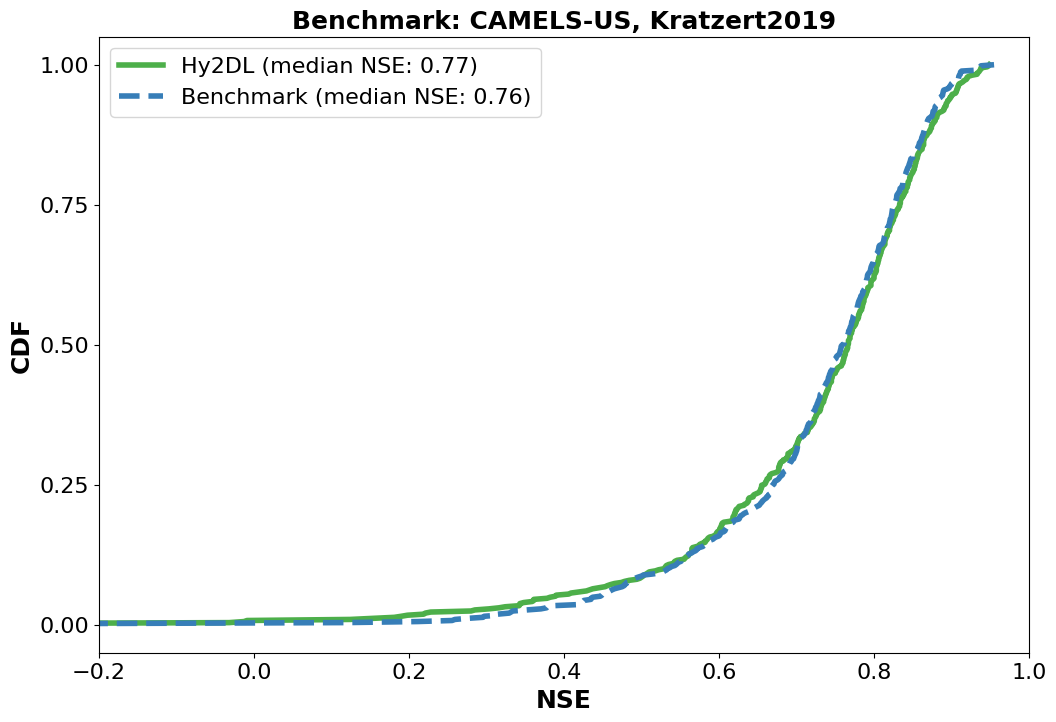

In [85]:
df_NSE_comparison = pd.concat([df_NSE_CAMELS_US, df_NSE_Kratzert], axis=1)
df_NSE_comparison = df_NSE_comparison.apply(lambda x: x.sort_values().values).reset_index(drop=True)
df_NSE_comparison["cdf"] = np.arange(len(df_NSE_comparison)) / (len(df_NSE_comparison) - 1)

# Create plot
plt.rcParams["figure.figsize"] = (12, 8)

plt.plot(
    df_NSE_comparison["LSTM"],
    df_NSE_comparison["cdf"],
    linewidth=4,
    label=f"Hy2DL (median NSE: {df_NSE_comparison['LSTM'].median():.2f})",
    color=color_palette["LSTM"],
)
plt.plot(
    df_NSE_comparison["Benchmark_Kratzert"],
    df_NSE_comparison["cdf"],
    linewidth=4,
    linestyle="--",
    label=f"Benchmark (median NSE: {df_NSE_comparison['Benchmark_Kratzert'].median():.2f})",
    color=color_palette["benchmark"],
)


plt.xlim(-0.2, 1)
plt.xlabel("NSE", fontsize=18, fontweight="bold")
plt.ylabel("CDF", fontsize=18, fontweight="bold")
plt.xticks(fontsize=16)
plt.yticks([i * 0.25 for i in range(5)], fontsize=16)

plt.legend(loc="upper left", fontsize=16)
plt.title("Benchmark: CAMELS-US, Kratzert2019", fontsize=18, fontweight="bold")
#plt.savefig("Benchmark_Kratzert2019.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.show()

Part 3. Benchmark hourly CAMELS_US.

Gauch, M., Kratzert, F., Klotz, D., Nearing, G., Lin, J., & Hochreiter, S. (2021). Rainfall–runoff prediction at multiple timescales with a single Long Short-Term Memory network. Hydrology and Earth System Sciences, 25(4), 2045–2062. https://doi.org/10.5194/hess-25-2045-2021

In [87]:
# Read the results generated by Gauch et al. (2021)
df_NSE_MTS = pd.read_csv("Gauch2021/NSE_MTS_benchmark.csv", index_col="basin_id", dtype={"basin_id": str})
df_NSE_sMTS = pd.read_csv("Gauch2021/NSE_sMTS_benchmark.csv", index_col="basin_id", dtype={"basin_id": str})
df_NSE_Naive = pd.read_csv("Gauch2021/NSE_Naive_benchmark.csv", index_col="basin_id", dtype={"basin_id": str})

# Read the results generated by Gauch et al. (2021)
df_NSE_MTS_FreqPerVar = pd.read_csv(
    "Gauch2021/NSE_MTS_multipleforcing_benchmark.csv", index_col="basin_id", dtype={"basin_id": str}
)

In [88]:
# First experiment: Same number of inputs for daily and hourly data.
path_results_LSTM = [
    "Gauch2021/camels_us_hourly_seed_110",
    "Gauch2021/camels_us_hourly_seed_111",
    "Gauch2021/camels_us_hourly_seed_222",
    "Gauch2021/camels_us_hourly_seed_333",
]

# Read information produced by ensemble of LSTMs and store it in dictionary of dataframes ----------------------------
lstm_results = {}
for i, ensemble_member in enumerate(path_results_LSTM):
    with open(ensemble_member + "/test_results.pickle", "rb") as f:
        info_lstm = pickle.load(f)
    # Iterate over each basin
    for basin in info_lstm.keys():
        y_sim = info_lstm[basin]["y_sim"]
        if i == 0:  # If this is the first ensemble member, initialize the DataFrame with y_obs and y_sim
            y_obs = info_lstm[basin]["y_obs"]
            lstm_results[basin] = pd.DataFrame(data={"y_obs": y_obs, f"y_sim_ens_{i + 1}": y_sim}, index=y_obs.index)
        else:  # For subsequent ensemble members, add y_sim as a new column
            lstm_results[basin][f"y_sim_ens_{i + 1}"] = y_sim

# Calculate the median of the simulated values and add it as a new column
for basin in lstm_results.keys():
    # Select only the y_sim columns
    y_sim_columns = [col for col in lstm_results[basin].columns if col.startswith("y_sim_ens_")]
    lstm_results[basin]["y_sim"] = lstm_results[basin][y_sim_columns].median(axis=1)

df_NSE_lstm_CAMELS_US_hourly = pd.DataFrame(
    data={"basin_id": list(lstm_results.keys()), "LSTM": np.round(nse(df_results=lstm_results, average=False), 3)}
).set_index("basin_id")

df_NSE_comparison_exp1 = pd.concat([df_NSE_lstm_CAMELS_US_hourly, df_NSE_MTS, df_NSE_sMTS, df_NSE_Naive], axis=1)
df_NSE_comparison_exp1 = df_NSE_comparison_exp1.apply(lambda x: x.sort_values().values).reset_index(drop=True)
df_NSE_comparison_exp1["cdf"] = np.arange(len(df_NSE_comparison_exp1)) / (len(df_NSE_comparison_exp1) - 1)

In [89]:
# Second experiment: Different number of inputs for daily and hourly data.
path_results_LSTM = [
    "Gauch2021/camels_us_hourly_ForcingsPerFreq_seed_110",
    "Gauch2021/camels_us_hourly_ForcingsPerFreq_seed_111",
    "Gauch2021/camels_us_hourly_ForcingsPerFreq_seed_222",
    "Gauch2021/camels_us_hourly_ForcingsPerFreq_seed_333",
]

# Read information produced by ensemble of LSTMs and store it in dictionary of dataframes ----------------------------
lstm_results = {}
for i, ensemble_member in enumerate(path_results_LSTM):
    with open(ensemble_member + "/test_results.pickle", "rb") as f:
        info_lstm = pickle.load(f)
    # Iterate over each basin
    for basin in info_lstm.keys():
        y_sim = info_lstm[basin]["y_sim"]
        if i == 0:  # If this is the first ensemble member, initialize the DataFrame with y_obs and y_sim
            y_obs = info_lstm[basin]["y_obs"]
            lstm_results[basin] = pd.DataFrame(data={"y_obs": y_obs, f"y_sim_ens_{i + 1}": y_sim}, index=y_obs.index)
        else:  # For subsequent ensemble members, add y_sim as a new column
            lstm_results[basin][f"y_sim_ens_{i + 1}"] = y_sim
# Calculate the mean of the simulated values and add it as a new column
for basin in lstm_results.keys():
    # Select only the y_sim columns
    y_sim_columns = [col for col in lstm_results[basin].columns if col.startswith("y_sim_ens_")]
    lstm_results[basin]["y_sim"] = lstm_results[basin][y_sim_columns].median(axis=1)

df_NSE_lstm_CAMELS_US_hourly = pd.DataFrame(
    data={"basin_id": list(lstm_results.keys()), "LSTM": np.round(nse(df_results=lstm_results, average=False), 3)}
).set_index("basin_id")

df_NSE_comparison_exp2 = pd.concat([df_NSE_lstm_CAMELS_US_hourly, df_NSE_MTS_FreqPerVar], axis=1)
df_NSE_comparison_exp2 = df_NSE_comparison_exp2.apply(lambda x: x.sort_values().values).reset_index(drop=True)
df_NSE_comparison_exp2["cdf"] = np.arange(len(df_NSE_comparison_exp2)) / (len(df_NSE_comparison_exp2) - 1)

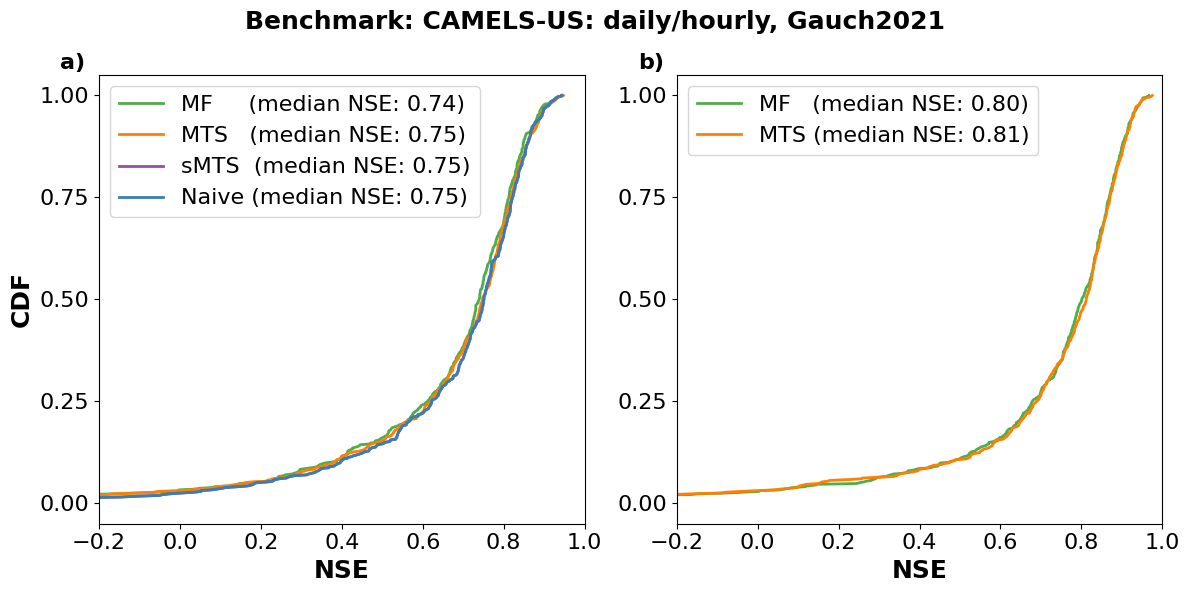

In [90]:
# Create a 2x1 subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot
axs[0].plot(
    df_NSE_comparison_exp1["LSTM"],
    df_NSE_comparison_exp1["cdf"],
    linewidth=2,
    label=f"MF     (median NSE: {df_NSE_comparison_exp1['LSTM'].median():.2f})",
    color=color_palette["LSTM"],
)
axs[0].plot(
    df_NSE_comparison_exp1["Benchmark_MTS"],
    df_NSE_comparison_exp1["cdf"],
    linewidth=2,
    label=f"MTS   (median NSE: {df_NSE_comparison_exp1['Benchmark_MTS'].median():.2f})",
    color=color_palette["MTS"],
)
axs[0].plot(
    df_NSE_comparison_exp1["Benchmark_sMTS"],
    df_NSE_comparison_exp1["cdf"],
    linewidth=2,
    label=f"sMTS  (median NSE: {df_NSE_comparison_exp1['Benchmark_sMTS'].median():.2f})",
    color=color_palette["sMTS"],
)
axs[0].plot(
    df_NSE_comparison_exp1["Benchmark_Naive"],
    df_NSE_comparison_exp1["cdf"],
    linewidth=2,
    label=f"Naive (median NSE: {df_NSE_comparison_exp1['Benchmark_Naive'].median():.2f})",
    color=color_palette["benchmark"],
)

# Set limits and labels for the first subplot
axs[0].set_xlim(-0.2, 1)
axs[0].set_xlabel("NSE", fontsize=18, fontweight="bold")
axs[0].set_ylabel("CDF", fontsize=18, fontweight="bold")
axs[0].tick_params(axis="both", labelsize=16)  # Set tick label size for both axes
axs[0].set_yticks(np.arange(0, 1.25, 0.25))  # Set y-ticks from 0 to 1 in increments of 0.25
axs[0].legend(loc="upper left", fontsize=16)
axs[0].text(-0.08, 1.05, "a)", transform=axs[0].transAxes, fontsize=16, fontweight="bold", verticalalignment="top")

# Second subplot
axs[1].plot(
    df_NSE_comparison_exp2["LSTM"],
    df_NSE_comparison_exp2["cdf"],
    linewidth=2,
    label=f"MF   (median NSE: {df_NSE_comparison_exp2['LSTM'].median():.2f})",
    color=color_palette["LSTM"],
)
axs[1].plot(
    df_NSE_comparison_exp2["Benchmark_MTS_multipleforcings"],
    df_NSE_comparison_exp2["cdf"],
    linewidth=2,
    label=f"MTS (median NSE: {df_NSE_comparison_exp2['Benchmark_MTS_multipleforcings'].median():.2f})",
    color=color_palette["MTS"],
)

# Set limits and labels for the second subplot
axs[1].set_xlim(-0.2, 1)
axs[1].set_xlabel("NSE", fontsize=18, fontweight="bold")
axs[1].tick_params(axis="both", labelsize=16)  # Set tick label size for both axes
axs[1].set_yticks(np.arange(0, 1.25, 0.25))  # Set y-ticks from 0 to 1 in increments of 0.25
axs[1].legend(loc="upper left", fontsize=16)
axs[1].text(-0.08, 1.05, "b)", transform=axs[1].transAxes, fontsize=16, fontweight="bold", verticalalignment="top")

fig.suptitle("Benchmark: CAMELS-US: daily/hourly, Gauch2021", fontsize=18, fontweight="bold")
# Adjust layout to prevent overlap
plt.tight_layout()
#plt.savefig("Benchmark_Gauch2021.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.show()


Part 4. Benchmark missing inputs.

Gauch, M., Kratzert, F., Klotz, D., Nearing, G., Cohen, D., and Gilon, O.: How to deal w___ missing input data, EGUsphere [preprint], https://doi.org/10.5194/egusphere-2025-1224, 2025.

In [2]:
def load_metrics(base_folder):
    data_dict = {}

    # Loop through all subfolders
    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)

        if os.path.isdir(subfolder_path):
            key = subfolder[-2:]  # last two characters of subfolder name
            dfs = []

            # Loop through all CSV files in the subfolder
            for file in os.listdir(subfolder_path):
                if file.endswith(".csv"):
                    csv_path = os.path.join(subfolder_path, file)
                    df = pd.read_csv(csv_path)

                    if "NSE" in df.columns:
                        col_name = file[-9:-4] if file.endswith(".csv") else file[-5:]
                        # safer: just take last 5 chars before ".csv"
                        col_name = os.path.splitext(file)[0][-5:]
                        
                        dfs.append(df["NSE"].rename(col_name))

            # Combine all NSE columns into one DataFrame (aligning by index)
            if dfs:
                combined_df = pd.concat(dfs, axis=1)
                data_dict[key] = combined_df

    return data_dict

In [49]:
path_results_nansweep = "Gauch2025/benchmark_nansweep_step_lr25_v2"
results_gauch_im = load_metrics(path_results_nansweep+"/im")
results_gauch_mme = load_metrics(path_results_nansweep+"/mme")

In [50]:
nan_probabilities = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

path_results_mme = [
    "Gauch2025/camels_us_missinginputs_mme_nanhandling_masked_mean_nanprob_0.0_seed_0",
    "Gauch2025/camels_us_missinginputs_mme_nanhandling_masked_mean_nanprob_0.1_seed_0",
    "Gauch2025/camels_us_missinginputs_mme_nanhandling_masked_mean_nanprob_0.2_seed_0",
    "Gauch2025/camels_us_missinginputs_mme_nanhandling_masked_mean_nanprob_0.3_seed_0",
    "Gauch2025/camels_us_missinginputs_mme_nanhandling_masked_mean_nanprob_0.4_seed_0",
    "Gauch2025/camels_us_missinginputs_mme_nanhandling_masked_mean_nanprob_0.5_seed_0",
    "Gauch2025/camels_us_missinginputs_mme_nanhandling_masked_mean_nanprob_0.6_seed_0",
]

path_results_ir = [
    "Gauch2025/camels_us_missinginputs_im_nanhandling_input_replacement_nanprob_0.0_seed_0",
    "Gauch2025/camels_us_missinginputs_im_nanhandling_input_replacement_nanprob_0.1_seed_0",
    "Gauch2025/camels_us_missinginputs_im_nanhandling_input_replacement_nanprob_0.2_seed_0",
    "Gauch2025/camels_us_missinginputs_im_nanhandling_input_replacement_nanprob_0.3_seed_0",
    "Gauch2025/camels_us_missinginputs_im_nanhandling_input_replacement_nanprob_0.4_seed_0",
    "Gauch2025/camels_us_missinginputs_im_nanhandling_input_replacement_nanprob_0.5_seed_0",
    "Gauch2025/camels_us_missinginputs_im_nanhandling_input_replacement_nanprob_0.6_seed_0",
]

results_mme = {}
for i, path_id in enumerate(path_results_mme):
    results_mme[nan_probabilities[i]] = pd.read_csv(path_id+"/NSE_testing.csv")

results_im = {}
for i, path_id in enumerate(path_results_ir):
    results_im[nan_probabilities[i]] = pd.read_csv(path_id+"/NSE_testing.csv")


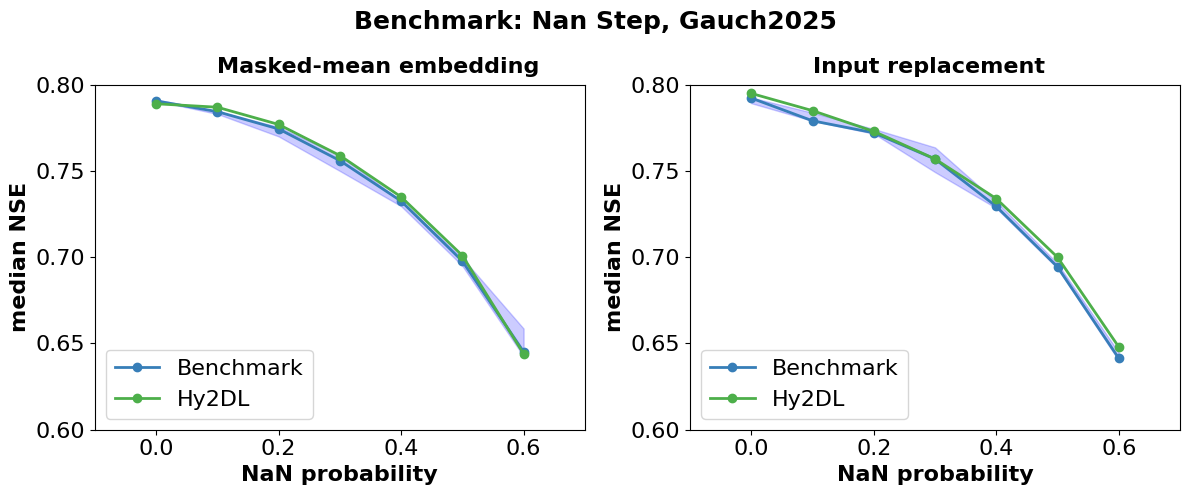

In [51]:
# Create a 2x1 subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
xs = [float(k)/10 for k in results_gauch_mme.keys()]
benchmark_median = [v.median().median() for v in results_gauch_mme.values()]
benchmark_max = [v.median().max() for v in results_gauch_mme.values()]
benchmark_min = [v.median().min() for v in results_gauch_mme.values()]
y_sim = [v["NSE"].median() for v in results_mme.values()]

axs[0].plot(xs, benchmark_median, linestyle="-", marker="o", linewidth=2, color=color_palette["benchmark"], label="Benchmark")
axs[0].fill_between(xs, benchmark_min, benchmark_max, color="blue", alpha=0.2)
axs[0].plot(xs, y_sim, linestyle="-", marker="o", linewidth=2, color=color_palette["LSTM"], label="Hy2DL")


# Set limits and labels for the first subplot
axs[0].set_xlim(-0.1, 0.7)
axs[0].set_ylim(0.6, 0.8)
axs[0].set_xlabel("NaN probability", fontsize=16, fontweight="bold")
axs[0].set_ylabel("median NSE", fontsize=16, fontweight="bold")
axs[0].set_yticks(np.arange(0.6, 0.85, 0.05))  # Set y-ticks from 0 to 1 in increments of 0.25
axs[0].tick_params(axis="both", labelsize=16)  # Set tick label size for both axes
axs[0].legend(loc="lower left", fontsize=16)
axs[0].text(0.25, 1.08, "Masked-mean embedding", transform=axs[0].transAxes, fontsize=16, fontweight="bold", verticalalignment="top")

# Second subplot
# First subplot
xs = [float(k)/10 for k in results_gauch_im.keys()]
benchmark_median = [v.median().median() for v in results_gauch_im.values()]
benchmark_max = [v.median().max() for v in results_gauch_im.values()]
benchmark_min = [v.median().min() for v in results_gauch_im.values()]
y_sim = [v["NSE"].median() for v in results_im.values()]

axs[1].plot(xs, benchmark_median, linestyle="-", marker="o", linewidth=2, color=color_palette["benchmark"], label="Benchmark")
axs[1].fill_between(xs, benchmark_min, benchmark_max, color="blue", alpha=0.2)
axs[1].plot(xs, y_sim, linestyle="-", marker="o", linewidth=2, color=color_palette["LSTM"], label="Hy2DL")


# Set limits and labels for the second subplot
# Set limits and labels for the first subplot
axs[1].set_xlim(-0.1, 0.7)
axs[1].set_ylim(0.6, 0.8)
axs[1].set_xlabel("NaN probability", fontsize=16, fontweight="bold")
axs[1].set_ylabel("median NSE", fontsize=16, fontweight="bold")
axs[1].set_yticks(np.arange(0.6, 0.85, 0.05))  # Set y-ticks from 0 to 1 in increments of 0.25
axs[1].tick_params(axis="both", labelsize=16)  # Set tick label size for both axes
axs[1].text(0.25, 1.08, "Input replacement", transform=axs[1].transAxes, fontsize=16, fontweight="bold", verticalalignment="top")
axs[1].legend(loc="lower left", fontsize=16)

fig.suptitle("Benchmark: Nan Step, Gauch2025", fontsize=18, fontweight="bold")
plt.tight_layout()
#plt.savefig("Benchmark_Gauch2025_NanStep.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.show()


In [3]:
def process_benchmark(path):
    df = pd.read_csv(path, index_col="basin", dtype={"basin": str})
    df["NSE"] = df.mean(axis=1)   
    df = df.apply(lambda x: x.sort_values().values).reset_index(drop=True)
    df["cdf"] = np.arange(len(df)) / (len(df) - 1)
    return df

In [4]:
def process_df(base_path, method, experiment):

    dfs = []
    for path in [subfolder for subfolder in os.listdir(base_path) if subfolder.startswith(f"camels_us_missingsequence_{method}")]:
            # read the CSV
            df = pd.read_csv(base_path +"/" + path + f"/NSE_testing_{experiment}.csv", index_col="basin_id", dtype={"basin_id": str})
            df = df[["NSE"]].rename(columns={"NSE": f"NSE_{path[-6:]}"})
            
            dfs.append(df)

    # concatenate along columns
    df = pd.concat(dfs, axis=1)
    df["NSE"] = df.mean(axis=1)   
    df = df.apply(lambda x: x.sort_values().values).reset_index(drop=True)
    df["cdf"] = np.arange(len(df)) / (len(df) - 1)

    return df

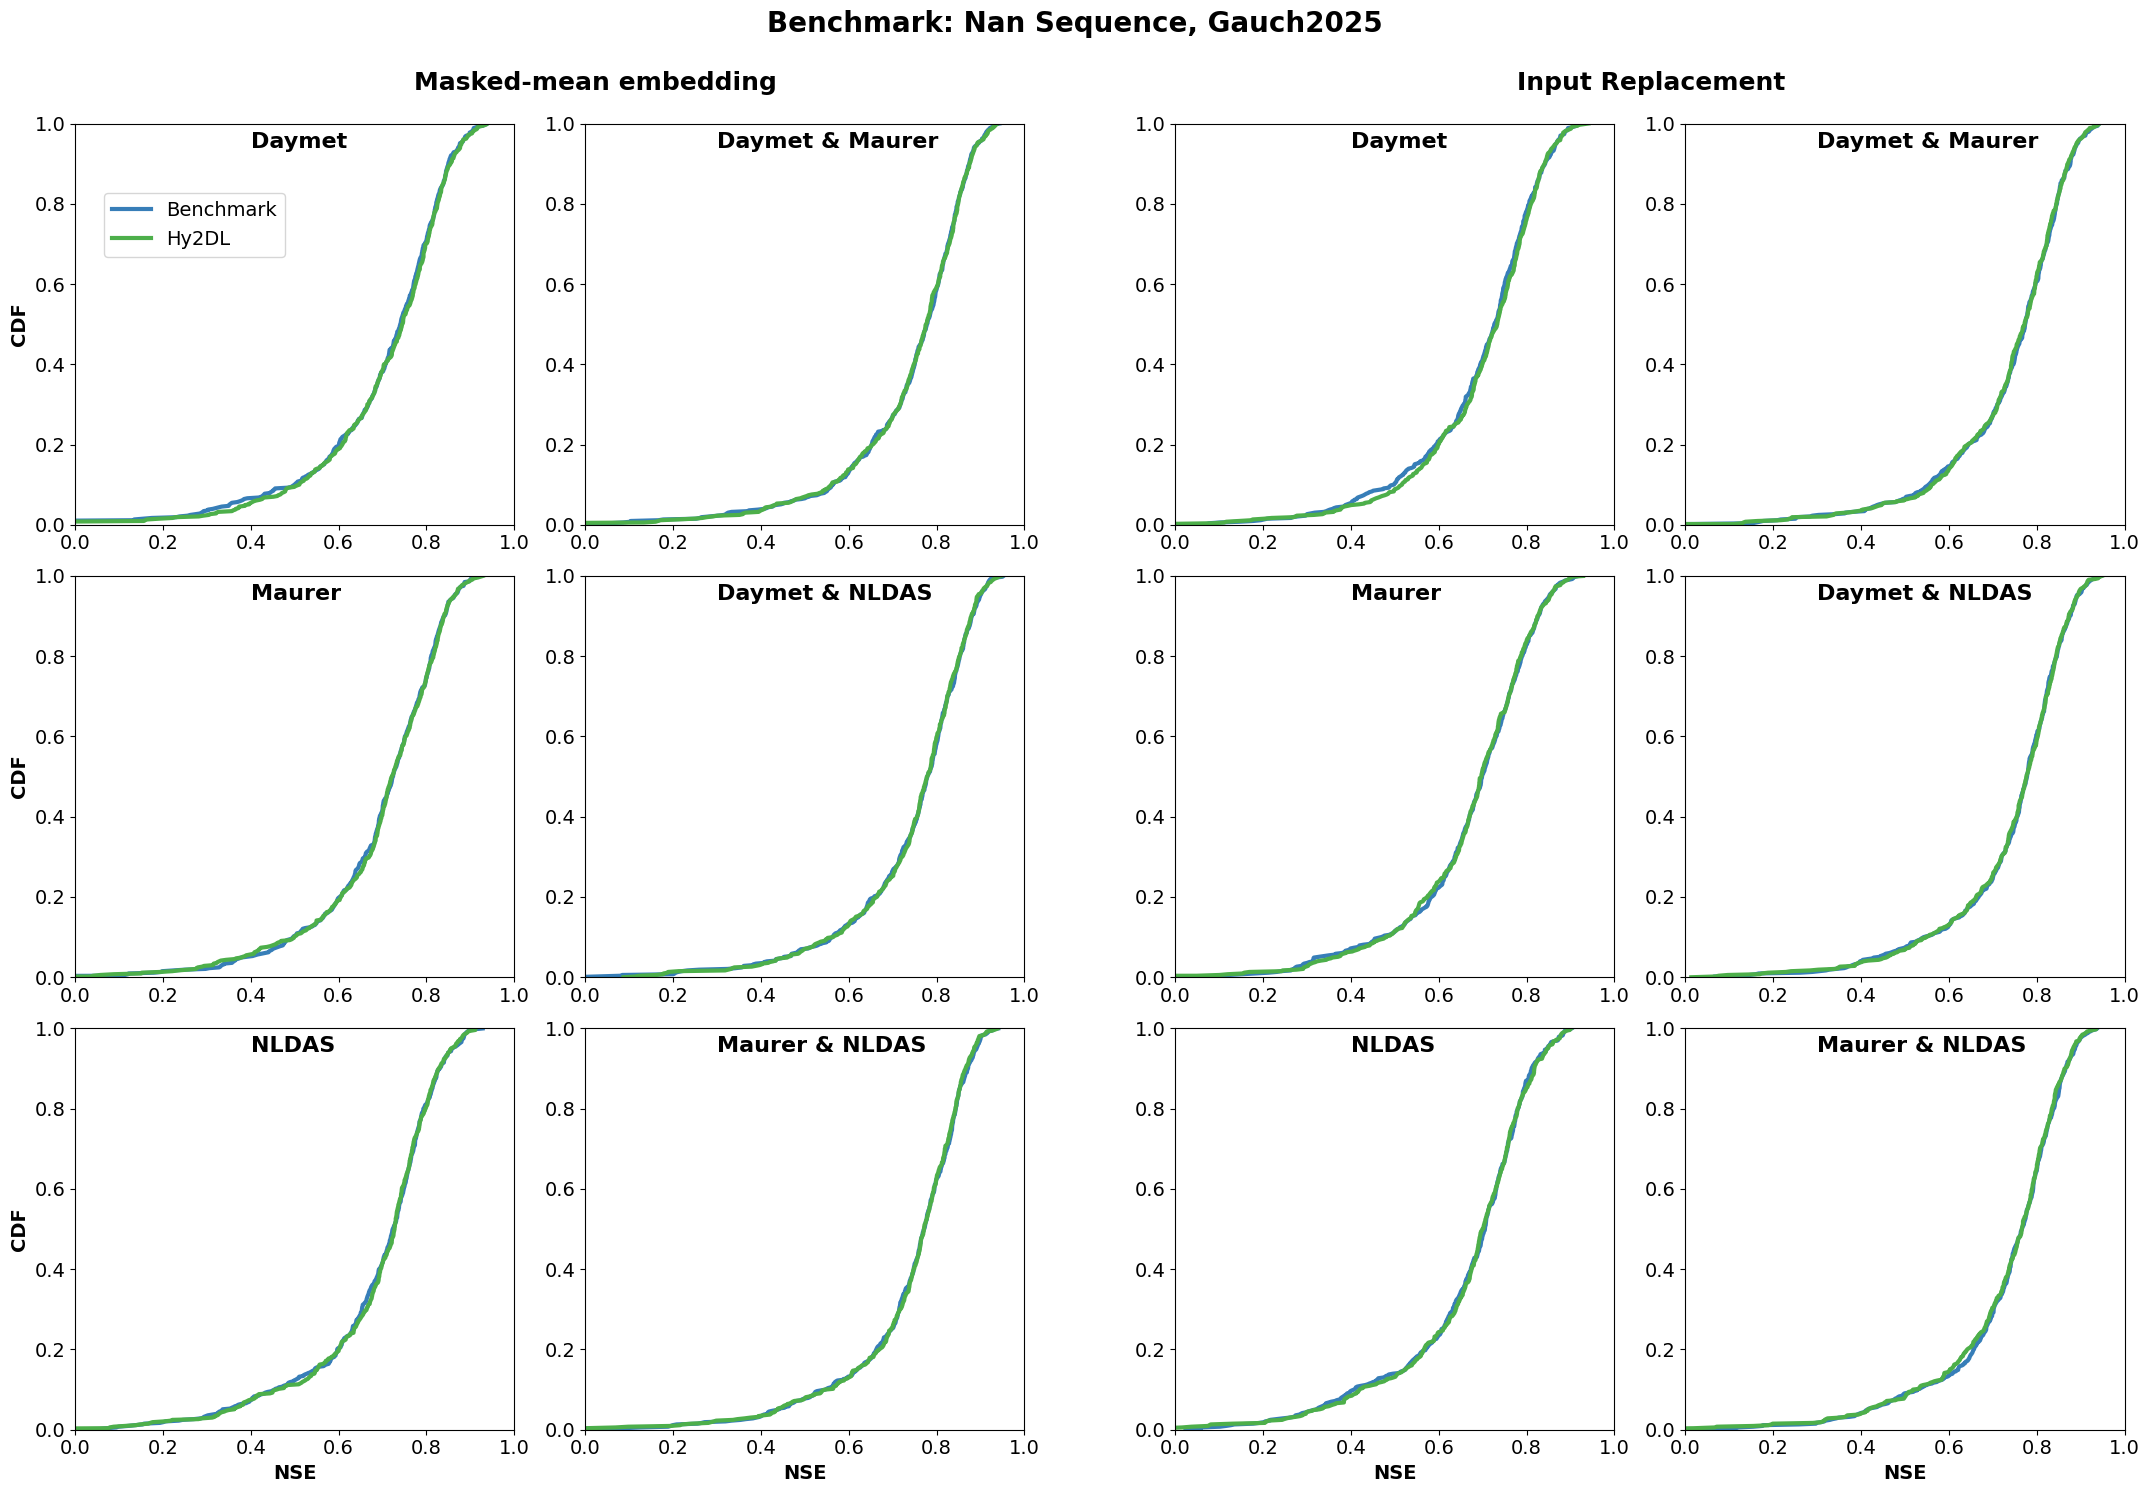

In [ ]:
fig = plt.figure(figsize=(24, 16))

# Create a GridSpec with 3 rows and 5 columns.
gs = fig.add_gridspec(3, 5, width_ratios=[1, 1, 0.02, 1, 1])

# Create a 3x4 numpy array to hold your axes objects, similar to what plt.subplots() returns
axs = np.empty((3, 4), dtype=object)

# Populate the axs array, manually handling shared axes
for r in range(3):
    for c in range(4):
        # Map the 4 plot columns to the 5 GridSpec columns, skipping the middle one
        grid_col = c if c < 2 else c + 1

        # Share axes with the top-left plot (axs[0,0])
        share_ax = {"sharex": axs[0, 0], "sharey": axs[0, 0]} if (r, c) != (0, 0) else {}

        axs[r, c] = fig.add_subplot(gs[r, grid_col], **share_ax)

### ---
# MME: Masked mean embedding
### ---

# Daymet
df_benchmark = process_benchmark("Gauch2025/benchmark_drop_sequence/mme/test_keepdaymet_metrics.csv")
axs[0, 0].plot(
    df_benchmark["NSE"], df_benchmark["cdf"], linewidth=3, color=color_palette["benchmark"], label="Benchmark"
)
df = process_df(base_path="Gauch2025", method="mme", experiment="daymet")
axs[0, 0].plot(df["NSE"], df["cdf"], linewidth=3, color=color_palette["LSTM"], label="Hy2DL")
axs[0, 0].text(
    0.4, 0.98, "Daymet", transform=axs[0, 0].transAxes, fontsize=16, fontweight="bold", verticalalignment="top"
)
axs[0, 0].set_ylabel("CDF", fontsize=14, fontweight="bold")
axs[0, 0].legend(loc="upper right", bbox_to_anchor=(0.50, 0.85), fontsize=14)


# Maurer
df_benchmark = process_benchmark("Gauch2025/benchmark_drop_sequence/mme/test_keepmaurer_metrics.csv")
axs[1, 0].plot(df_benchmark["NSE"], df_benchmark["cdf"], linewidth=3, color=color_palette["benchmark"])
df = process_df(base_path="Gauch2025", method="mme", experiment="maurer")
axs[1, 0].plot(df["NSE"], df["cdf"], linewidth=3, color=color_palette["LSTM"])
axs[1, 0].text(
    0.4, 0.98, "Maurer", transform=axs[1, 0].transAxes, fontsize=16, fontweight="bold", verticalalignment="top"
)
axs[1, 0].set_ylabel("CDF", fontsize=14, fontweight="bold")


# NLDAS
df_benchmark = process_benchmark("Gauch2025/benchmark_drop_sequence/mme/test_keepnldas_metrics.csv")
axs[2, 0].plot(df_benchmark["NSE"], df_benchmark["cdf"], linewidth=3, color=color_palette["benchmark"])
df = process_df(base_path="Gauch2025", method="mme", experiment="nldas")
axs[2, 0].plot(df["NSE"], df["cdf"], linewidth=3, color=color_palette["LSTM"])
axs[2, 0].text(
    0.4, 0.98, "NLDAS", transform=axs[2, 0].transAxes, fontsize=16, fontweight="bold", verticalalignment="top"
)
axs[2, 0].set_xlabel("NSE", fontsize=14, fontweight="bold")
axs[2, 0].set_ylabel("CDF", fontsize=14, fontweight="bold")


# Daymet & Maurer
df_benchmark = process_benchmark("Gauch2025/benchmark_drop_sequence/mme/test_keepdaymet_maurer_metrics.csv")
axs[0, 1].plot(df_benchmark["NSE"], df_benchmark["cdf"], linewidth=3, color=color_palette["benchmark"])
df = process_df(base_path="Gauch2025", method="mme", experiment="daymet_maurer")
axs[0, 1].plot(df["NSE"], df["cdf"], linewidth=3, color=color_palette["LSTM"])
axs[0, 1].text(
    0.3, 0.98, "Daymet & Maurer", transform=axs[0, 1].transAxes, fontsize=16, fontweight="bold", verticalalignment="top"
)


# Daymet & NLDAS
df_benchmark = process_benchmark("Gauch2025/benchmark_drop_sequence/mme/test_keepdaymet_nldas_metrics.csv")
axs[1, 1].plot(df_benchmark["NSE"], df_benchmark["cdf"], linewidth=3, color=color_palette["benchmark"])
df = process_df(base_path="Gauch2025", method="mme", experiment="daymet_nldas")
axs[1, 1].plot(df["NSE"], df["cdf"], linewidth=3, color=color_palette["LSTM"])
axs[1, 1].text(
    0.3, 0.98, "Daymet & NLDAS", transform=axs[1, 1].transAxes, fontsize=16, fontweight="bold", verticalalignment="top"
)


# Maurer & NLDAS
df_benchmark = process_benchmark("Gauch2025/benchmark_drop_sequence/mme/test_keepmaurer_nldas_metrics.csv")
axs[2, 1].plot(df_benchmark["NSE"], df_benchmark["cdf"], linewidth=3, color=color_palette["benchmark"])
df = process_df(base_path="Gauch2025", method="mme", experiment="maurer_nldas")
axs[2, 1].plot(df["NSE"], df["cdf"], linewidth=3, color=color_palette["LSTM"])
axs[2, 1].text(
    0.3, 0.98, "Maurer & NLDAS", transform=axs[2, 1].transAxes, fontsize=16, fontweight="bold", verticalalignment="top"
)
axs[2, 1].set_xlabel("NSE", fontsize=14, fontweight="bold")

### ---
# IR: Input replacement
### ---

# Daymet
df_benchmark = process_benchmark("Gauch2025/benchmark_drop_sequence/im/test_keepdaymet_metrics.csv")
axs[0, 2].plot(df_benchmark["NSE"], df_benchmark["cdf"], linewidth=3, color=color_palette["benchmark"])
df = process_df(base_path="Gauch2025", method="im", experiment="daymet")
axs[0, 2].plot(df["NSE"], df["cdf"], linewidth=3, color=color_palette["LSTM"])
axs[0, 2].text(
    0.4, 0.98, "Daymet", transform=axs[0, 2].transAxes, fontsize=16, fontweight="bold", verticalalignment="top"
)

# Maurer
df_benchmark = process_benchmark("Gauch2025/benchmark_drop_sequence/im/test_keepmaurer_metrics.csv")
axs[1, 2].plot(df_benchmark["NSE"], df_benchmark["cdf"], linewidth=3, color=color_palette["benchmark"])
df = process_df(base_path="Gauch2025", method="im", experiment="maurer")
axs[1, 2].plot(df["NSE"], df["cdf"], linewidth=3, color=color_palette["LSTM"])
axs[1, 2].text(
    0.4, 0.98, "Maurer", transform=axs[1, 2].transAxes, fontsize=16, fontweight="bold", verticalalignment="top"
)

# NLDAS
df_benchmark = process_benchmark("Gauch2025/benchmark_drop_sequence/im/test_keepnldas_metrics.csv")
axs[2, 2].plot(df_benchmark["NSE"], df_benchmark["cdf"], linewidth=3, color=color_palette["benchmark"])
df = process_df(base_path="Gauch2025", method="im", experiment="nldas")
axs[2, 2].plot(df["NSE"], df["cdf"], linewidth=3, color=color_palette["LSTM"])
axs[2, 2].text(
    0.4, 0.98, "NLDAS", transform=axs[2, 2].transAxes, fontsize=16, fontweight="bold", verticalalignment="top"
)
axs[2, 2].set_xlabel("NSE", fontsize=14, fontweight="bold")

# Daymet & Maurer
df_benchmark = process_benchmark("Gauch2025/benchmark_drop_sequence/im/test_keepdaymet_maurer_metrics.csv")
axs[0, 3].plot(df_benchmark["NSE"], df_benchmark["cdf"], linewidth=3, color=color_palette["benchmark"])
df = process_df(base_path="Gauch2025", method="im", experiment="daymet_maurer")
axs[0, 3].plot(df["NSE"], df["cdf"], linewidth=3, color=color_palette["LSTM"])
axs[0, 3].text(
    0.3, 0.98, "Daymet & Maurer", transform=axs[0, 3].transAxes, fontsize=16, fontweight="bold", verticalalignment="top"
)

# Daymet & NLDAS
df_benchmark = process_benchmark("Gauch2025/benchmark_drop_sequence/im/test_keepdaymet_nldas_metrics.csv")
axs[1, 3].plot(df_benchmark["NSE"], df_benchmark["cdf"], linewidth=3, color=color_palette["benchmark"])
df = process_df(base_path="Gauch2025", method="im", experiment="daymet_nldas")
axs[1, 3].plot(df["NSE"], df["cdf"], linewidth=3, color=color_palette["LSTM"])
axs[1, 3].text(
    0.3, 0.98, "Daymet & NLDAS", transform=axs[1, 3].transAxes, fontsize=16, fontweight="bold", verticalalignment="top"
)

# Maurer & NLDAS
df_benchmark = process_benchmark("Gauch2025/benchmark_drop_sequence/im/test_keepmaurer_nldas_metrics.csv")
axs[2, 3].plot(df_benchmark["NSE"], df_benchmark["cdf"], linewidth=3, color=color_palette["benchmark"])
df = process_df(base_path="Gauch2025", method="im", experiment="maurer_nldas")
axs[2, 3].plot(df["NSE"], df["cdf"], linewidth=3, color=color_palette["LSTM"])
axs[2, 3].text(
    0.3, 0.98, "Maurer & NLDAS", transform=axs[2, 3].transAxes, fontsize=16, fontweight="bold", verticalalignment="top"
)
axs[2, 3].set_xlabel("NSE", fontsize=14, fontweight="bold")


for ax in axs.flat:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_yticks(np.arange(0, 1.2, 0.2))
    ax.tick_params(axis="both", labelsize=14)

# --- Add column subtitles ---
fig.text(0.30, 0.93, "Masked-mean embedding", ha="center", fontsize=18, fontweight="bold")
fig.text(0.74, 0.93, "Input Replacement", ha="center", fontsize=18, fontweight="bold")

fig.suptitle("Benchmark: Nan Sequence, Gauch2025", fontsize=20, fontweight="bold")
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
#plt.savefig("Benchmark_Gauch2025_NanSequence.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.show()